In [1]:
import os
import pandas as pd
import numpy as np
import random

import sys
sys.path.insert(0, '..')

from unpast.run_unpast import unpast
from unpast.utils.method import prepare_input_matrix 
from unpast.utils.consensus import make_consensus_biclusters
from unpast.utils.io import read_bic_table, write_bic_table

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from unpast.utils.eval import calculate_perfromance, evaluate_overlaps_ARI,apply_bh

from unpast.utils.figs import draw_heatmap2
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# specify output folder and output file prefix
fname= "data/ST/GSE250138_anca_samples_processed"
basename = 'ST'
out_dir = "ST_results/"
# input .tsv file; features in rows, samples in columns
exprs_file = fname+".tsv.gz" 

In [3]:
n_runs = 5
analysis_seed = 0
random.seed(analysis_seed)
seeds = []
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

generate  5  seeds [885440, 403958, 794772, 933488, 441001]


In [4]:
biclustering_results = []
for seed in seeds:
    results = unpast(exprs_file, basename,
                  out_dir=out_dir,
                  seed=seed,
                  verbose= False
                 )
    # make bicluster ids unique: 'seed=<seed>_<bicluster id>'
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values ]
    biclustering_results.append(results)
    print("seed = %s\tn_biclusters: %s"%(seed, results.shape[0]))

seed = 885440	n_biclusters: 160
seed = 403958	n_biclusters: 165
seed = 794772	n_biclusters: 155
seed = 933488	n_biclusters: 164
seed = 441001	n_biclusters: 176


In [5]:
exprs_z = prepare_input_matrix(pd.read_csv(exprs_file,sep="\t",index_col = 0), min_n_samples=5,ceiling=3)
consensus_biclusters = make_consensus_biclusters(biclustering_results, 
                                                 exprs_z,
                                                 seed = analysis_seed,
                                                 verbose = False,
                                                 plot = False)
print(consensus_biclusters.shape[0])
consensus_biclusters.head(3)

sknetwork version used: 0.33.0


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
0,3.618431,2,36,"{GJA8, CYP1A2}","{GTCGCGTAACCCGTTG-1_V3_A, AAATTTGCGGGTGTGG-1_V...","{GJA8, CYP1A2}",{},"{980, 12607}","{3328, 8323, 4228, 6661, 6287, 8850, 9106, 283...",UP,4,"{seed=441001_0, seed=933488_1, seed=885440_0, ..."
1,3.49952,2,22,"{FBXO47, WDR87}","{TACGACTGCCTCTTAG-1_V3_A, CTTTCTGTGCGGGCTT-1_V...","{FBXO47, WDR87}",{},"{15481, 13975}","{2688, 5131, 8845, 1686, 8855, 9116, 4125, 438...",UP,2,"{seed=403958_3, seed=885440_2}"
2,3.381516,2,20,"{SI, OR5B12}","{TTACTCTGGTACGTAC-1_V3_A, GAGTCCGCTTACCGGA-1_V...","{SI, OR5B12}",{},"{3772, 9661}","{10243, 9870, 10128, 5010, 414, 8096, 8993, 50...",UP,2,"{seed=441001_1, seed=403958_5}"


In [4]:
outfile = out_dir+"/"+basename+".consensus_seed="+str(analysis_seed)
outfile += ".biclusters.tsv" 
print(outfile)

ST_results//ST.consensus_seed=0.biclusters.tsv


#### save consensus biclusters for ANCA

In [6]:
write_bic_table(consensus_biclusters,outfile)
print(consensus_biclusters.shape[0])

187


#### or load precomputed biclusters for ANCA and expression

In [7]:
#consensus_biclusters =  read_bic_table(outfile)
#print(consensus_biclusters.shape[0])
#exprs = pd.read_csv(exprs_file,sep="\t",index_col = 0)
#exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)

In [8]:
annot = pd.read_csv("data/ST/GSE250138_anca_samples_processed.obs.tsv.gz",sep  ="\t",index_col=0)
annot = annot.loc[:,["Sample","leiden_1","leiden_2","annot_v2","cluster_annot","cluster_annot_broad"]] # ["Sample","leiden_1","leiden_2","annot_v2","cluster_annot","cluster_annot_broad"]
annot = annot.fillna("NA")
annot.head(3)

,Sample,leiden_1,leiden_2,annot_v2,cluster_annot,cluster_annot_broad
AAACGAGACGGTTGAT-1_V5_A,V5_A,3,6,NA,Inflamed tubulointerstitial,Inflamed tubulointerstitial
AAATAGGGTGCTATTG-1_V5_A,V5_A,1,9,NA,PT/LOH,Tubular
AAATTTGCGGGTGTGG-1_V5_A,V5_A,4,15,NA,PT/LOH,Tubular


In [9]:
color_dict = {}

color_dict["cluster_annot"] = {'CNT/PC': '#00441B',
 'CNT/PC/IC': '#1B7837',
 'DCT/CNT': '#5AAE61',
 'Inflamed glomerular': '#900D09', #
 'Inflamed tubulointerstitial': '#d62728', #
 'LOH': '#E7D4E8',
 'Normal glomerular': '#d2d40b', #
 'PT': '#C2A5CF',
 'PT/DCT': '#9970AB',
 'PT/LOH': '#9E9AC8',
 'PT/TAL': 'violet', # in ctrl dataset
 'Tubulointerstitial': '#c49c94', #
 'Tubulointerstitial/Vessels':"orange", # only in ctrl
 'Vasculature': '#ffa500'}

color_dict.keys()


dict_keys(['cluster_annot'])

In [10]:
len(set(annot["Sample"].values))

19

## identify biclusters wihich contain known biomarkers

immune - immune cells, endo - endothelium, vSCMPericyte - vascular smooth muscle cells and pericytes,
LOH - loop of henle, TAL - thick ascending limb of LOH, Thin limb - thin ascending limb of LOH,
IC - intercalated cells, PC - principal cells, CNT - connecting tubules, 
PT - proximal tubules, DCT- distal convoluted tubules


In [11]:
# From Engesser et al., 2021 supplementary Fig. 1c
markers = {
"immune":["PTPRC","CD3D","CD14","CD19"],
"podocyte":["PTPRQ","WT1","NTNG1","NPHS1","NPHS2","CLIC5","PODXL"],
"fibroblast":["COL1A1","COL1A2","C7","NEGR1","FBLN5","DCN","CDH11"],
"vSCMPericyte":["NOTCH3","PDGFRB","ITGA8"],  # not found by UnPaSt
"endo":["CD34","PECAM1","PTPRB","MEIS2","EMCN"], # not found by UnPaSt
"TAL":["CASR","SLC12A1","UMOD"],
"Thin limb":["CRYAB","TACSTD2","SLC44A5","KLRG2","COL26A1","BOC"],
"IC":["ATP6V0D2","ATP6V1C2","TMEM213","CLNK"],
"PC":["GATA3","AQP2","AQP3"],
"CNT":["SLC8A1","SCN2A","HSD11B2","CALB1"],
"DCT":["SLC12A3","CNNM2","FGF13","KLHL3","LHX1","TRPM6"],
"PT":["LRP2","CUBN","SLC13A1"]
}

marker_color_dict = {
"immune":"red",
"podocyte":"gold",
"fibroblast":"grey",
"vSCMPericyte":"magenta", 
"endo":"orange",   
"TAL":"pink",     # thick ascending limb LOH
"Thin limb":"lightblue", # Thin ascending limb LOH
"IC":"lightgreen", # intercalated cells everywhere in collecting duct system 
"PC":"darkgreen",      # principal cells - collect Na+ in collecting ducts
"CNT":"lime",      # connecting tubules - last part ofnephron
"DCT":"darkviolet", # distal convoluted tubules
"PT":"plum", # proximal tubules
}

marker_order =  ["CNT","IC","PC","immune","TAL","Thin limb","endo","podocyte","PT",
                 "DCT", "fibroblast","vSCMPericyte"]

samlpes_in_biclusters = set([])

sele_bic_ids = []
sele_genes = []
bic_to_marker = {}
marker_genes = set([])
for m in markers.keys():
    mset = set(markers[m])
    marker_genes |= mset
    bics_w_markers = consensus_biclusters[consensus_biclusters["genes"].apply(lambda x: len(x.intersection(mset)))>0]
    if bics_w_markers.shape[0]>0:
        print(m) #, sorted(mset)
        for bic_id in bics_w_markers.index:
            samlpes_in_biclusters |= consensus_biclusters.loc[bic_id,"samples"]
            if not bic_id in bic_to_marker.keys():
                bic_to_marker[bic_id] = m
                genes = bics_w_markers.loc[bic_id,"genes"]
                print("\t b."+str(bic_id), genes.intersection(mset))
                #print("\t".join([m, str(bic_id),
                #                 " ".join(genes.intersection(mset)),
                #                " ".join(genes)]))
                sele_genes+= sorted(genes)
                sele_bic_ids.append(bic_id)
    else:
        print(m,"not found")
marker_genes = sorted(marker_genes)
samples_not_in_biclusters = set(exprs_z.columns.values).difference(set(samlpes_in_biclusters))
print("spots not in any biclusters",len(samples_not_in_biclusters))

immune
	 b.152 {'PTPRC'}
podocyte
	 b.116 {'CLIC5', 'NPHS2', 'WT1', 'PODXL', 'NTNG1', 'PTPRQ', 'NPHS1'}
fibroblast
	 b.154 {'COL1A1'}
vSCMPericyte not found
endo not found
TAL
	 b.126 {'SLC12A1', 'UMOD', 'CASR'}
Thin limb
	 b.139 {'TACSTD2'}
IC
	 b.129 {'TMEM213', 'ATP6V0D2', 'CLNK', 'ATP6V1C2'}
PC
	 b.132 {'AQP3', 'AQP2'}
	 b.177 {'GATA3'}
CNT
	 b.140 {'HSD11B2'}
DCT
	 b.161 {'TRPM6', 'SLC12A3'}
PT
	 b.121 {'LRP2'}
	 b.125 {'SLC13A1', 'CUBN'}
spots not in any biclusters 82


129	IC	 AQP6 ATP6V0A4 ATP6V0D2 ATP6V1C2 ATP6V1G3 CALB1 CKMT2 CLDN8 CLNK DMRT2 FOXI1 HEPACAM2 INPP5J KIT PIK3C2G PTGER3 RHBG RHCG SLC26A7 SLC4A1 SLC4A9 SLC52A3 SLC8A1 SPINK1 STAP1 TMEM213 TMPRSS2
132	PC	 ADGRF1 AQP2 AQP3 BMPR1B CPAMD8 EHF ELF5 FXYD4 HMGCS2 L1CAM PFKFB3 PRR35 SCNN1B SCNN1G STC1
140	CNT	 ASAP2 CKB CLDN7 COBLL1 CYFIP2 DEFB1 EFHD1 HOXB3 HOXD4 HSD11B2 IDH2 IVNS1ABP MAL MPC1 MUC1 MUC20 RAP1GAP SCIN SCNN1A TFCP2L1 TRIM2 VAV3 WFDC2
152	immune	 ARHGAP45 CD37 CORO1A LIMD2 LSP1 LYZ PTPRC TMC8
126	TAL	 ACPP BDKRB2 CACNA2D3 CASR CLCNKA CLDN16 CLDN19 DUSP9 EGF ESRRB GP2 GSTM3 HOXB6 HSPA2 IRX1 IRX2 KCNJ1 KNG1 MECOM MFSD4A MTURN PADI2 POU3F3 PPP1R1A PROM2 RANBP3L SCTR SIM2 SLC12A1 SLC5A3 SLC9A3 TFAP2B TMEM72 TSPAN8 UMOD WNK4
139	Thin limb	 ITGB6 KRT7 RASD1 S100A2 SLC16A5 SLC34A2 SLPI TACSTD2
116	podocyte	 ADAMTS19 AL590560.2 ARMH4 C1QL1 CHI3L1 CLIC5 CRB2 CRHBP DDN EHD3 F3 FGF1 HTRA1 IL1RL1 KLK6 KLK7 LMX1B MYLK3 NDNF NES NPHS1 NPHS2 NTNG1 PCOLCE2 PHYHIP PLA2R1 PODXL PTPRO PTPRQ SOST SPO

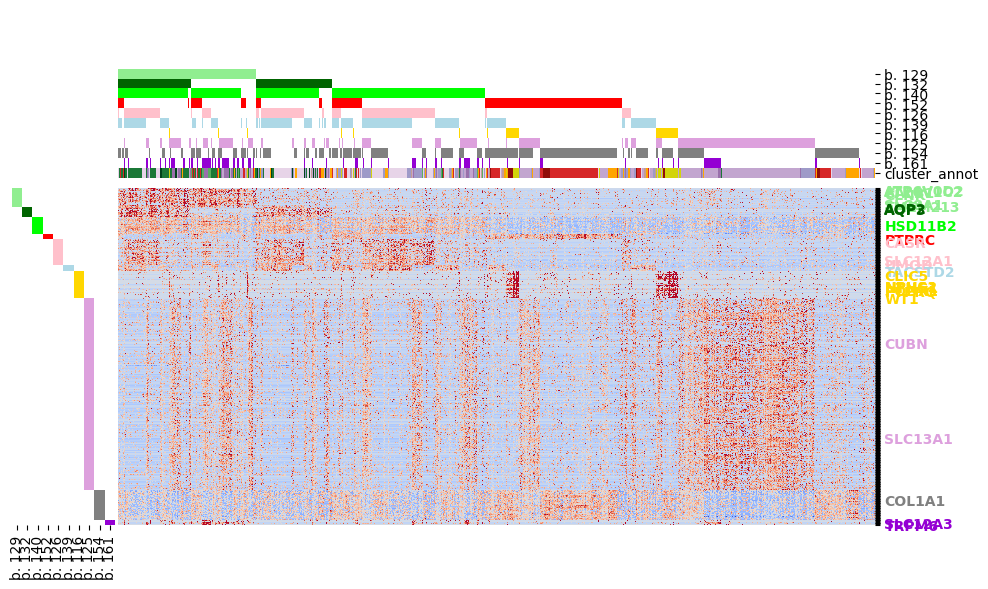

In [12]:
i = [129, 132, 140, 152, 126, 139, 116, 125, 154, 161] # bics. 121 and 177 are not shown
bic_colors = [marker_color_dict[bic_to_marker[bic_id]] for bic_id in i]
b = consensus_biclusters.loc[i,:]
b["genes"] = b["genes"].apply(lambda x: x.intersection(set(exprs_z.index)))
b["genes_up"] = b["genes_up"].apply(lambda x: x.intersection(set(exprs_z.index)))
b["genes_down"] = b["genes_down"].apply(lambda x: x.intersection(set(exprs_z.index)))

g, sample_order, (row_colors, col_colors) = draw_heatmap2(exprs_z, b,
                    annot = annot.loc[:,["cluster_annot"]], 
                    color_dict=color_dict,
              bicluster_colors= bic_colors,#"black",
              figsize = (10,6), 
              dendrogram_ratio=(0.0,0.1),
              colors_ratio=(0.02/10*6, 0.02),
              bic_prefix = "b. ",
              legend_n_cols=0,
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              no_row_colors = False,
                    cluster_rows=False,
                    highlight_row_labels=marker_genes
             )


ytick_labels = [label.get_text() for label in g.ax_heatmap.get_yticklabels()]
new_ytick_labels = ["" if label not in marker_genes else label for label in ytick_labels]
g.ax_heatmap.set_yticklabels(new_ytick_labels)

ax = g.ax_heatmap
ax.set_ylabel("")
ax.set_xlabel("ANCA spots (n=%s)"%exprs_z.shape[1])
ax.set_xlabel("")

#plt.savefig("ST_results/FigSX_Detected_in_ANCA.biclusters_with_markers.png",dpi = 600)
for bic_id in b.index:
    print(str(bic_id)+"\t"+bic_to_marker[bic_id]+"\t"," ".join(sorted(b.loc[bic_id,"genes"])))

data = g.data2d
plt.show()



### how many compartments per spot? 

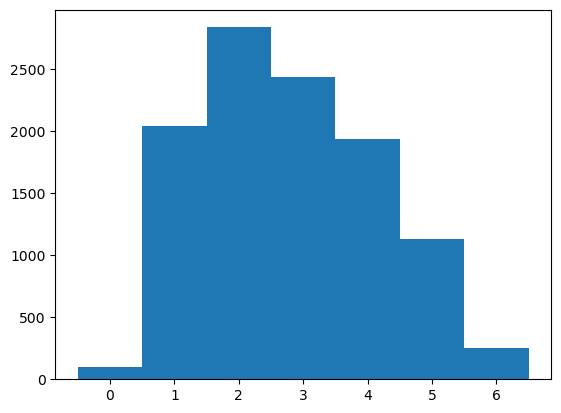

In [13]:
df_spots = pd.DataFrame(np.zeros((len(marker_order),exprs_z.shape[1])),
                       index = marker_order,
                       columns= exprs_z.columns)
for bic_id in  [129, 132, 140, 152, 126, 139, 116, 125, 154, 161]:
    marker = bic_to_marker [bic_id]
    spots = sorted(consensus_biclusters.loc[bic_id, "samples"])
    df_spots.loc[marker,spots] = 1
# two biclusters correspond to PT, 125 and 121
bic_id= 121
marker = bic_to_marker [bic_id]
spots = sorted(consensus_biclusters.loc[bic_id, "samples"])
df_spots.loc[marker,spots] = 1

tmp = plt.hist(df_spots.sum(), range = [-0.5,6.5], bins = 7) 

In [14]:
# in exactly one compartments
df_spots.sum()[df_spots.sum()==1].shape[0]

2042

In [17]:
# in none of the compartments
df_spots.sum()[df_spots.sum()==0].shape[0]

98

In [18]:
df_spots.sum().mean()

2.8036792715785563

## plot biomarker expression for clusters 

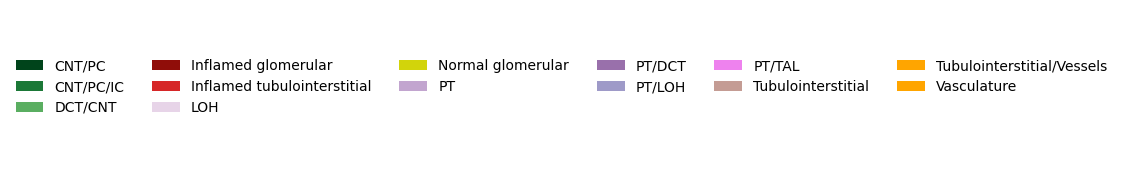

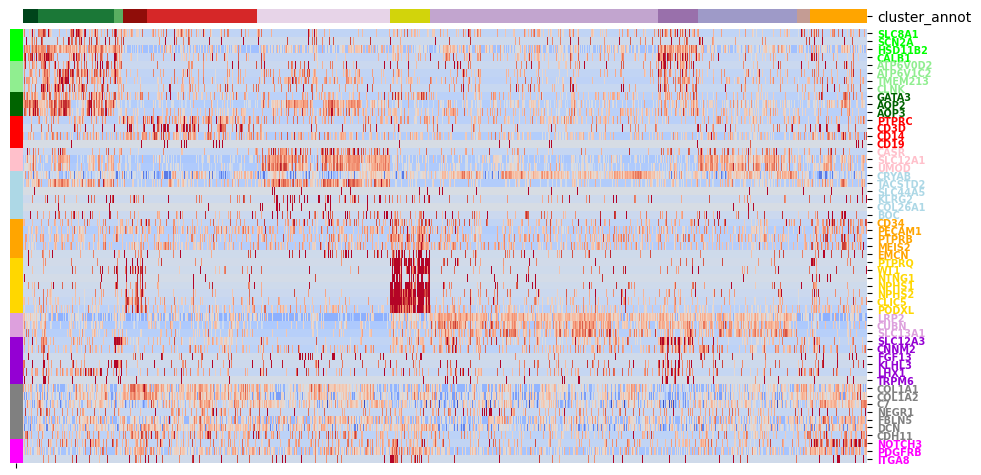

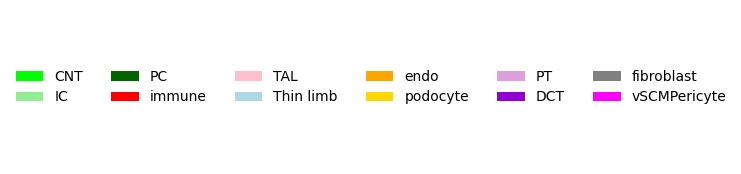

In [19]:
import seaborn as sns
from matplotlib.patches import Patch


sample_order = exprs_z.columns.values
cols = ["cluster_annot"]
annotation = annot.loc[:,:].copy()
col_colors = annotation.loc[:,cols]
cluster_columns = True
no_cbar = True

for col in reversed(cols):
    col_color_map = color_dict[col]
    col_colors[col] = col_colors[col].apply(lambda x: col_color_map[x])
    for subt in list(col_color_map.keys()):
        subt_samples = annotation.loc[annotation[col] == subt, :].index
        if cluster_columns:
            new_sample_order = [
                x for x in sample_order if x not in subt_samples
            ] + [x for x in sample_order if x in subt_samples]
            sample_order = new_sample_order

            
m_colors = []
feature_order = []
for m in marker_order:
    feature_order += markers[m]
    c = marker_color_dict[m]
    m_colors+=[c]*len(markers[m])
m_colors = pd.Series(m_colors, index=feature_order)



# Number of columns in the legend
n_cols = 6
# Create legend elements
legend_elements = [Patch(facecolor=color, label=label) for label, color in color_dict["cluster_annot"].items()]
# Plot an empty figure and add the legend
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')  # Hide axes
ax.legend(handles=legend_elements, ncol=n_cols, loc='center', frameon=False)
plt.savefig("ST_results/FigSX_ST_ANCA_compartments.pdf")
plt.show()

g = sns.clustermap(
        exprs_z.loc[feature_order, sample_order],
        figsize=(10,5),
        col_cluster=False,
        row_cluster=False,
        dendrogram_ratio=(0.01,0.01),
        colors_ratio=(0.03/10*5,0.03),
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        vmin=-3,
        vmax=3,
        xticklabels=False,
        yticklabels=True,
        col_colors=col_colors,
        row_colors=m_colors,
    )
ax = g.ax_heatmap
#ax.set_ylabel("")
#ax.set_xlabel("ANCA spots (n=%s)"%exprs_z.shape[1])
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# g.cax.set_position([.10, .2, .03, .45])
# from https://stackoverflow.com/questions/47350879/seaborn-clustermap-subplots-adjust-cancels-colour-bar-relocation
dendro_box = g.ax_row_dendrogram.get_position()
dendro_box.x0 = (dendro_box.x0 + 2 * dendro_box.x1) / 3
g.cax.set_position(dendro_box)
# Move the ticks to the left (https://stackoverflow.com/a/36939552/1878788)
g.cax.yaxis.set_ticks_position("left")

if no_cbar:
        g.ax_cbar.set_visible(False)
        
highlight_row_labels = marker_genes # marker genes
for row_tick in ax.get_yticklabels():
    if row_tick.get_text() in highlight_row_labels:
        
        row_tick.set_weight("bold")
        for m_id in marker_order:
            if row_tick.get_text() in markers[m_id]:
                row_tick.set_color(marker_color_dict[m_id])
plt.savefig("ST_results/FigSX_ST_ANCA_biomarkers.png", dpi=600)
plt.show()
# Number of columns in the legend
n_cols = 6
# Create legend elements
legend_elements = []
for label in marker_order:
    color = marker_color_dict[label]
    legend_elements.append(Patch(facecolor=color, label=label))
# Plot an empty figure and add the legend
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')  # Hide axes
ax.legend(handles=legend_elements, ncol=n_cols, loc='center', frameon=False)
#plt.savefig("ST_results/FigSX_ST_ANCA_bic_color_legend.svg")
plt.show()

# ANCA + CTRL

* ANCA: 10763 spots
* CTRL: 9065 spots 
* Total: 19828 

In [20]:
outfile = out_dir+"/"+basename+".consensus_seed="+str(analysis_seed)
outfile += ".biclusters.tsv" 
from unpast.utils.io import read_bic_table
consensus_biclusters = read_bic_table(outfile)

In [21]:
annot2 = pd.read_csv("data/ST/GSE250138_anca_and_ctrl_samples_processed.obs.tsv",sep  ="\t",index_col=0)
annot2 = annot2.loc[annot2["Cohort"]=='Internal',:]
annot2.head(3)

/tmp/ipykernel_71117/2163891334.py:1: DtypeWarning: Columns (33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  annot2 = pd.read_csv("data/ST/GSE250138_anca_and_ctrl_samples_processed.obs.tsv",sep  ="\t",index_col=0)


,in_tissue,array_row,array_col,Sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,region_Medulla_score,region_Papilla_score,leiden_2,cluster_annot_broad,annot_v1,count_v1,annot_v2,count_v2,batch,Cohort
AAACAATCTACTAGCA-1_CTRL1_C-0,1.0,3.0,43.0,CTRL1_C,1514,7.323171,1955.0,7.578657,11.764706,18.005115,...,NaN,NaN,NaN,Tubules,NaN,NaN,NaN,NaN,0,Internal
AAACAGAGCGACTCCT-1_CTRL1_C-0,1.0,14.0,94.0,CTRL1_C,2216,7.703910,3248.0,8.086103,11.052956,17.333744,...,NaN,NaN,NaN,Tubules,NaN,NaN,NaN,NaN,0,Internal
AAACCCGAACGAAATC-1_CTRL1_C-0,1.0,45.0,115.0,CTRL1_C,977,6.885510,1174.0,7.069024,13.884157,22.402044,...,NaN,NaN,NaN,Normal glomerular,NaN,NaN,NaN,NaN,0,Internal


In [22]:
slides = sorted(set(annot2["Sample"].values))
sl_colors = sns.color_palette("colorblind",len(slides)).as_hex()
color_dict["Sample"] = dict(zip(slides,sl_colors))

color_dict["Condition"] = {'ANCA':"pink", 'CTRL':"lightgreen"} 

In [23]:
len(set(annot2.loc[annot2["Condition"]=="ANCA","Sample"].values))

19

In [24]:
set(annot2.loc[annot2["Condition"]=="CTRL","Sample"].values)

{'CTRL1_B', 'CTRL1_C', 'CTRL1_D'}

In [25]:
exprs_file2 = "data/ST/GSE250138_anca_and_ctrl_samples_processed.tsv"
# filter and z-score transform input matrix
exprs_z2 = prepare_input_matrix(pd.read_csv(exprs_file2,sep="\t",index_col = 0).loc[:,annot2.index], min_n_samples=5,ceiling=3)
exprs_z2.shape[1]

19828

In [26]:
annot2.index =["-".join(x.split("-")[:2]) for x in annot2.index]
exprs_z2.columns =["-".join(x.split("-")[:2]) for x in exprs_z2.columns]
annot2.head(3)

,in_tissue,array_row,array_col,Sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,region_Medulla_score,region_Papilla_score,leiden_2,cluster_annot_broad,annot_v1,count_v1,annot_v2,count_v2,batch,Cohort
AAACAATCTACTAGCA-1_CTRL1_C,1.0,3.0,43.0,CTRL1_C,1514,7.323171,1955.0,7.578657,11.764706,18.005115,...,NaN,NaN,NaN,Tubules,NaN,NaN,NaN,NaN,0,Internal
AAACAGAGCGACTCCT-1_CTRL1_C,1.0,14.0,94.0,CTRL1_C,2216,7.703910,3248.0,8.086103,11.052956,17.333744,...,NaN,NaN,NaN,Tubules,NaN,NaN,NaN,NaN,0,Internal
AAACCCGAACGAAATC-1_CTRL1_C,1.0,45.0,115.0,CTRL1_C,977,6.885510,1174.0,7.069024,13.884157,22.402044,...,NaN,NaN,NaN,Normal glomerular,NaN,NaN,NaN,NaN,0,Internal


In [27]:
annot_ctrl = annot2.loc[annot2["Condition"]=="CTRL",:]
annot_anca = annot2.loc[annot2["Condition"]=="ANCA",:]

exprs_anca_z = exprs_z2.loc[:,annot_anca.index.values]
exprs_ctrl_z = exprs_z2.loc[:,annot_ctrl.index.values]
exprs_ctrl_z.head(2)

,AAACAATCTACTAGCA-1_CTRL1_C,AAACAGAGCGACTCCT-1_CTRL1_C,AAACCCGAACGAAATC-1_CTRL1_C,AAACCGGAAATGTTAA-1_CTRL1_C,AAACCGGGTAGGTACC-1_CTRL1_C,AAACCGTTCGTCCAGG-1_CTRL1_C,AAACCTAAGCAGCCGG-1_CTRL1_C,AAACGAAGAACATACC-1_CTRL1_C,AAACGGGCGTACGGGT-1_CTRL1_C,AAACGGGTTGGTATCC-1_CTRL1_C,...,TTGTGCGGAAGCGGAT-1_CTRL1_B,TTGTGGTAGGAGGGAT-1_CTRL1_B,TTGTGGTATAGGTATG-1_CTRL1_B,TTGTGTATGCCACCAA-1_CTRL1_B,TTGTGTTTCCCGAAAG-1_CTRL1_B,TTGTTCAGTGTGCTAC-1_CTRL1_B,TTGTTGTGTGTCAAGA-1_CTRL1_B,TTGTTTCACATCCAGG-1_CTRL1_B,TTGTTTCATTAGTCTA-1_CTRL1_B,TTGTTTCCATACAACT-1_CTRL1_B
SAMD11,-0.364664,2.624835,-0.364664,-0.364664,-0.364664,3.000000,-0.364664,-0.364664,-0.364664,-0.364664,...,-0.364664,-0.364664,1.682036,-0.364664,-0.364664,-0.364664,-0.364664,-0.364664,-0.364664,-0.364664
NOC2L,-0.592057,1.795795,-0.592057,-0.592057,-0.592057,-0.592057,-0.592057,-0.592057,-0.592057,-0.592057,...,-0.592057,0.964422,-0.592057,-0.592057,-0.592057,-0.592057,-0.592057,-0.592057,-0.592057,-0.592057


## Select ANCA-specific biclusters
* keep only genes expressed in both ANCA and CTRL
* divide CTRL samples based on ANCA bicluster genes
* select biclusters:
 - over-expressed in ANCA: avg. z-score > 0.5
 - expression is higher in ANCA than in CTRL: avg. z-score in high-expession group in ANCA exceeds CTRL for at least 0.5

In [28]:
from unpast.utils.method import cluster_samples, update_bicluster_data

def find_similar_biclusters(bics, # discovered biclsuters
                            exprs_z, # new expression data 
                            seed = analysis_seed,
                            min_n_genes = 2,
                            min_n_samples=5
                           ):
    new_bics = {} # biclusters in new expression data similar to known biclusters
    gene_sets_stats = {}
    all_samples = set(exprs_z.columns)
    for bic_id in bics.index.values:
        g = bics.loc[bic_id,"genes"]
        gene_sets_stats[bic_id] = {"genes":g,"n_genes":len(g)}
        # keep only genes presenting in expression data
        g = sorted(g.intersection(set(exprs_z.index.values)))
        gene_sets_stats[bic_id].update({"genes_measured":g,"n_genes_measured":len(g)})
        if len(g)> min_n_genes:
            e = exprs_z.loc[g, :]
            b = cluster_samples(e.T,min_n_samples=min_n_samples,seed=seed)
            b["genes"] = set(g)
            b["n_genes"] = len(b["genes"])
            if "sample_indexes" in b.keys():
                # update and bicluster data
                b = update_bicluster_data(b, e)
            new_bics[bic_id] = b
            
    new_bics = pd.DataFrame.from_dict(new_bics).T
    gene_sets_stats = pd.DataFrame.from_dict(gene_sets_stats).T
    return new_bics, gene_sets_stats

In [29]:
# ANCA
anca_bics, anca_gs_stat = find_similar_biclusters(consensus_biclusters,
                                                  exprs_anca_z)
# keep genes in expressed in both
for col in ["genes", "genes_up","genes_down"]:
    anca_bics["genes"] = anca_bics["genes"].apply(lambda row: row.intersection(set(exprs_anca_z.index.values)))

# CTRL
ctrl_bics, ctrl_gs_stat = find_similar_biclusters(consensus_biclusters,
                                                  exprs_ctrl_z)

In [30]:
d1 = anca_bics.loc[:,["n_samples","SNR","genes", "n_genes"]]
d1.columns = "ANCA_"+d1.columns 
d2 = ctrl_bics.loc[:,["n_samples","SNR","genes", "n_genes"]]
d2.columns = "CTRL_"+d2.columns 
compared_bics = pd.concat([d1,d2],axis=1).fillna(0)

for bic_id in compared_bics.index.values:
    compared_bics.loc[bic_id,"mean_z_ANCA"] = exprs_z2.loc[sorted(anca_bics.loc[bic_id,"genes"]),
                      sorted(anca_bics.loc[bic_id,"samples"])].stack().dropna().mean()
    mean_ctrl_z = exprs_z2.loc[sorted(ctrl_bics.loc[bic_id,"genes"]),
                      sorted(ctrl_bics.loc[bic_id,"samples"])].stack().dropna().mean()
    if mean_ctrl_z <0: 
        s_ = sorted(set(annot_ctrl.index).difference(ctrl_bics.loc[bic_id,"samples"]))
        mean_ctrl_z_ = exprs_z2.loc[sorted(ctrl_bics.loc[bic_id,"genes"]),
                                   s_].stack().dropna().mean()
        if mean_ctrl_z_ > mean_ctrl_z:
            compared_bics.loc[bic_id,"CTRL_n_samples"] = len(s_)
            mean_ctrl_z = mean_ctrl_z_
    compared_bics.loc[bic_id,"mean_z_CTRL"] = mean_ctrl_z

compared_bics["mean_z_diff"] = compared_bics["mean_z_ANCA"] -  compared_bics["mean_z_CTRL"]
compared_bics = compared_bics.sort_values(by = "mean_z_diff",ascending = False)

compared_bics = compared_bics.loc[compared_bics["mean_z_diff"]>0.5,:]

compared_bics.sort_values("ANCA_n_genes",ascending=False)

,ANCA_n_samples,ANCA_SNR,ANCA_genes,ANCA_n_genes,CTRL_n_samples,CTRL_SNR,CTRL_genes,CTRL_n_genes,mean_z_ANCA,mean_z_CTRL,mean_z_diff
154,5000,1.415011,"{COL3A1, HLA-DPA1, PLXND1, CD99, CAVIN1, TAGLN...",42,3995,1.198144,"{COL3A1, HLA-DPA1, PLXND1, CD99, CAVIN1, TAGLN...",42,0.735888,-0.182448,0.918335
145,2502,1.512726,"{IGHG2, POU2AF1, IGHM, IGHA1, ZBP1, IGKC, IGHG...",18,526,0.792745,"{IGHG2, IGHG3, POU2AF1, IGHA1, JCHAIN, IGKC, Z...",18,1.066201,-0.106994,1.173195
120,1420,1.839932,"{RSAD2, OAS3, IFI44L, XAF1, IFI44, OAS2, IFI6,...",10,1133,0.717403,"{RSAD2, OAS3, IFI44L, XAF1, IFI44, OAS2, IFI6,...",10,1.539125,0.036784,1.502342
152,2895,1.442993,"{LIMD2, CORO1A, CD37, ARHGAP45, TMC8, LYZ, PTP...",8,896,0.728677,"{LIMD2, CORO1A, CD37, ARHGAP45, TMC8, LYZ, PTP...",8,1.121175,0.105887,1.015287
148,2428,1.466834,"{TRBC2, CD52, TRBC1, TRAC, RAC2, LTB}",6,505,1.239981,"{RAC2, TRBC2, CD52, TRBC1, TRAC, LTB}",6,1.196395,0.228424,0.967971
146,4243,1.508671,"{NNMT, LCN2, SERPINA3, C3, LTF}",5,1059,1.031917,"{NNMT, LCN2, SERPINA3, C3, LTF}",5,1.073896,-0.074636,1.148532
147,3528,1.490958,"{VSIG4, CD163, C1QA, HCLS1, FCGR3A}",5,836,1.023563,"{VSIG4, CD163, C1QA, HCLS1, FCGR3A}",5,1.139102,0.163259,0.975843
151,3377,1.493645,"{FCER1G, IL10RA, CTSS, SPI1}",4,840,1.236277,"{SPI1, IL10RA, CTSS, FCER1G}",4,1.169555,0.273605,0.895950
150,4215,1.445583,"{SPON2, CDH6, DLGAP1, HAVCR1}",4,2561,0.815268,"{SPON2, CDH6, DLGAP1, HAVCR1}",4,0.908804,0.185107,0.723697
143,2848,1.299324,"{SLC11A1, FCGR3A, S100A8, S100A9}",4,623,1.765245,"{SLC11A1, FCGR3A, S100A8, S100A9}",4,1.099207,0.485417,0.613790


In [31]:
len(compared_bics.sort_values(by = "ANCA_n_samples",ascending = False).index.values)

15

In [32]:
d = compared_bics.sort_values("ANCA_n_genes",ascending=False)
d = pd.concat([d, consensus_biclusters.loc[d.index,["sample_indexes"]]],axis=1)
d["ANCA_genes"] = d["ANCA_genes"].apply(lambda x: " ".join(sorted(x)))
d.to_csv("ST_results/ANCA_specific/TableS7b.tsv",sep="\t")

## plot ANCA-associated biclusters 
### IFNA response 

b.120: IFI27 IFI44 IFI44L IFI6 ISG15 MX1 OAS2 OAS3 RSAD2 XAF1


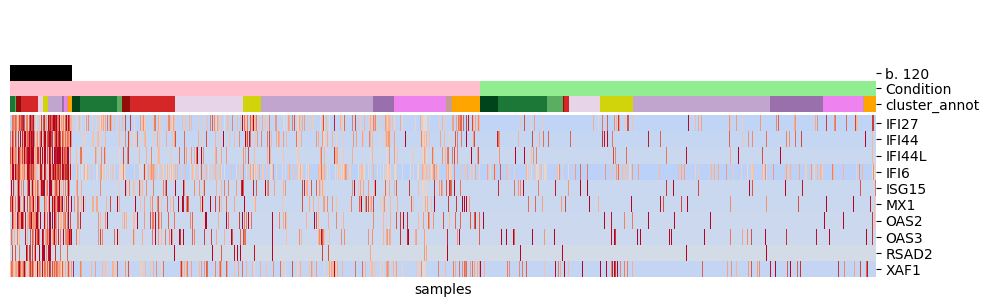

In [33]:
i = [120] # lymphoid cells
b = anca_bics.loc[i,:]

tmp = draw_heatmap2(exprs_z2, b,
                    annot = annot2.loc[:,["Condition","cluster_annot"]], 
                    color_dict=color_dict,
              bicluster_colors= "black",
              figsize = (10,3), 
              dendrogram_ratio=(0.0,0.2),
              colors_ratio=(0.06/10*3, 0.06),
              bic_prefix = "b. ",
              #legend_n_cols=6,
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              no_row_colors = True,
              cluster_rows=False
             )

#plt.savefig("ST_results/Detected_in_ANCA.bic154.png")
for bic_id in b.index:
    print("b."+str(bic_id)+":"," ".join(sorted(b.loc[bic_id,"genes"])))

### Lymphoid cells

b.148: CD52 LTB RAC2 TRAC TRBC1 TRBC2
b.152: ARHGAP45 CD37 CORO1A LIMD2 LSP1 LYZ PTPRC TMC8
b.141: CD53 CXCR4 IKZF1 IL7R
b.145: CD79A DERL3 FCRL5 IGHA1 IGHG1 IGHG2 IGHG3 IGHG4 IGHM IGKC IGLC1 IRF4 JCHAIN MZB1 PIM2 POU2AF1 TENT5C ZBP1


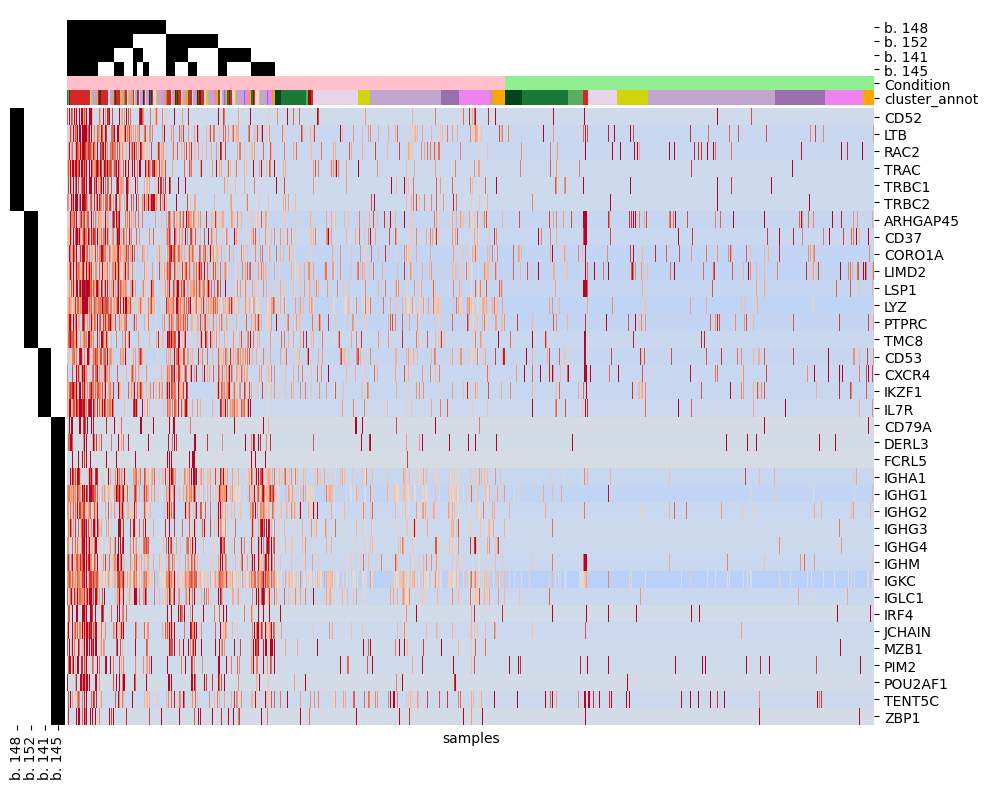

In [34]:
i = [148,152,141,145] # lymphoid cells
b = anca_bics.loc[i,:]

tmp = draw_heatmap2(exprs_z2, b,
                    annot = annot2.loc[:,["Condition","cluster_annot"]], 
                    color_dict=color_dict,
              bicluster_colors= "black",
              figsize = (10,8), 
              dendrogram_ratio=(0.0,0.01),
              colors_ratio=(0.02/10*8, 0.02),
              bic_prefix = "b. ",
              legend_n_cols=0,
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              no_row_colors = False,
              cluster_rows=False
             )

#plt.savefig("ST_results/Detected_in_ANCA.bic154.png")
for bic_id in b.index:
    print("b."+str(bic_id)+":"," ".join(sorted(b.loc[bic_id,"genes"])))
    
    
    

### Myeloid cells

b.144: CSF1R ITGB2 MS4A6A
b.147: C1QA CD163 FCGR3A HCLS1 VSIG4
b.151: CTSS FCER1G IL10RA SPI1


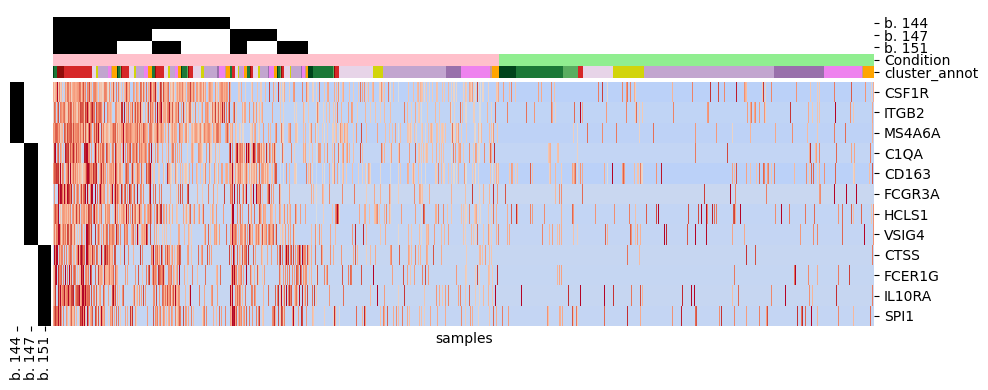

In [35]:
i = [144, 147, 151] 
b = anca_bics.loc[i,:]

tmp = draw_heatmap2(exprs_z2, b,
                    annot = annot2.loc[:,["Condition","cluster_annot"]], 
                    color_dict=color_dict,
              bicluster_colors= "black",
              figsize = (10,4), 
              dendrogram_ratio=(0.0,0.01),
              colors_ratio=(0.04/10*4, 0.04),
              bic_prefix = "b. ",
              legend_n_cols=0,
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              no_row_colors = False,
              cluster_rows=False
             )

#plt.savefig("ST_results/Detected_in_ANCA.bic154.png")
for bic_id in b.index:
    print("b."+str(bic_id)+":"," ".join(sorted(b.loc[bic_id,"genes"])))

### Others

b.146: C3 LCN2 LTF NNMT SERPINA3
b.150: CDH6 DLGAP1 HAVCR1 SPON2
b.142: CCL19 CCL21 PTGDS


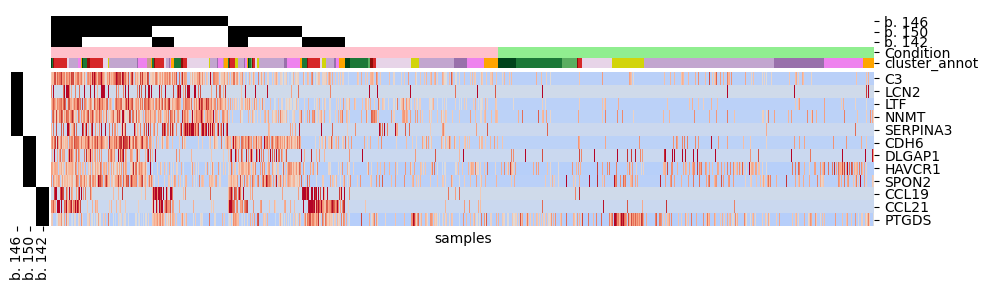

In [36]:
i = [146,150,142] 
b = anca_bics.loc[i,:]
tmp = draw_heatmap2(exprs_z2, b,
                    annot = annot2.loc[:,["Condition","cluster_annot"]],
                    color_dict=color_dict,
              bicluster_colors= "black",
              figsize = (10,3), 
              dendrogram_ratio=(0.0,0.01),
              colors_ratio=(0.05/10*3, 0.05),
              bic_prefix = "b. ",
              legend_n_cols=0,
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              no_row_colors = False,
              cluster_rows=False
             )

#plt.savefig("ST_results/Detected_in_ANCA.bic154.png")
for bic_id in b.index:
    print("b."+str(bic_id)+":"," ".join(sorted(b.loc[bic_id,"genes"])))

b.154: ACTA2 AEBP1 AHNAK ARHGDIB ARPC1B BGN BST2 C1QB C1QC C1R C1S CAVIN1 CD99 COL1A1 COL3A1 COL6A2 EHBP1L1 EMILIN1 FSTL1 GGT5 HLA-DPA1 HLA-DPB1 HLA-F IFITM2 LAPTM5 LUM MARCKS MGP PLXND1 RNASE1 RNASET2 STAB1 TAGLN TGM2 TIMP1 TIMP2 TMSB4X TNC TPM2 TYROBP WIPF1 ZYX


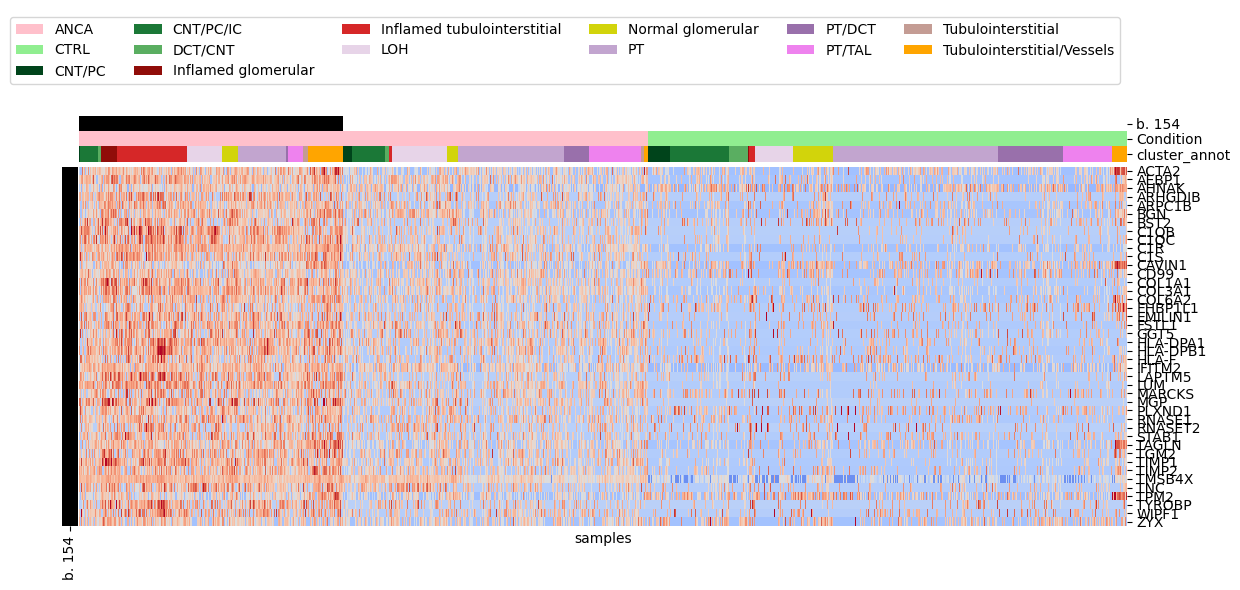

In [37]:
i = [154] 
# 154 some kind of macrophages (TYROBP, C1QC,C1QB) and fibroblasts (LUM,C1R)
b = anca_bics.loc[i,:]
b["genes"] = b["genes"].apply(lambda x: x.intersection(set(exprs_z2.index)))
b["genes_up"] = b["genes_up"].apply(lambda x: x.intersection(set(exprs_z2.index)))
b["genes_down"] = b["genes_down"].apply(lambda x: x.intersection(set(exprs_z2.index)))

tmp = draw_heatmap2(exprs_z2, b,
                    annot = annot2.loc[:,["Condition","cluster_annot"]], 
                    color_dict=color_dict,
              bicluster_colors= "black",
              figsize = (12,6), 
              dendrogram_ratio=(0.0,0.2),
              colors_ratio=(0.03/12*6, 0.03),
              bic_prefix = "b. ",
              legend_n_cols=6,
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              no_row_colors = False,
              cluster_rows=False
             )

#plt.savefig("ST_results/Detected_in_ANCA.bic154.png")
for bic_id in b.index:
    print("b."+str(bic_id)+":"," ".join(sorted(b.loc[bic_id,"genes"])))

### proliferation 

b.159: MKI67 TOP2A TPX2 TROAP UBE2C


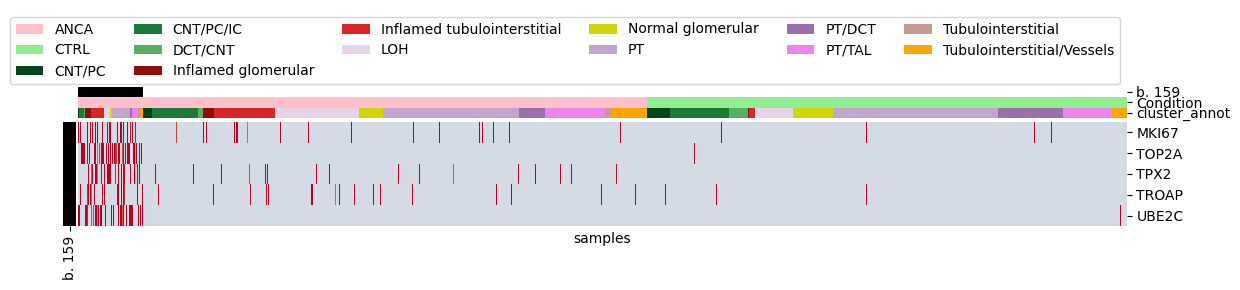

In [38]:
i = [159] 

b = anca_bics.loc[i,:]
b["genes"] = b["genes"].apply(lambda x: x.intersection(set(exprs_z2.index)))
b["genes_up"] = b["genes_up"].apply(lambda x: x.intersection(set(exprs_z2.index)))
b["genes_down"] = b["genes_down"].apply(lambda x: x.intersection(set(exprs_z2.index)))

tmp = draw_heatmap2(exprs_z2, b,
                    annot = annot2.loc[:,["Condition","cluster_annot"]], 
                    color_dict=color_dict,
              bicluster_colors= "black",
              figsize = (12,3), 
              dendrogram_ratio=(0.0,0.35),
              colors_ratio=(0.05/12*3, 0.05),
              bic_prefix = "b. ",
              legend_n_cols=6,
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              no_row_colors = False,
              cluster_rows=False
             )

#plt.savefig("ST_results/Detected_in_ANCA.bic154.png")
for bic_id in b.index:
    print("b."+str(bic_id)+":"," ".join(sorted(b.loc[bic_id,"genes"])))

# plot heatmaps for an individual slides

In [39]:
# display only a subset of markers 
my_markers = {
    "IFN response":['IFI27', 'ISG15', 'OAS3'],#['IFI27', 'IFI44', 'ISG15', 'MX1','OAS3',],
    "B-cells":['CD79A', 'FCRL5', 'IGHG3', 'IGHM'],
    "T-cells":['LTB', 'TRAC' ],
    "podocytes": ["PODXL","NPHS1"],
}
my_marker_color_dict = {
    "IFN response":"darkblue",
    "B-cells":"red",
    "T-cells": "magenta",
    "podocytes": "gold",
}
my_marker_genes= set([])

bic_to_my_groups = {}
for bic_id in consensus_biclusters.index.values:
    bic_genes = consensus_biclusters.loc[bic_id,"genes"]
    for group in my_markers.keys():
        g = set(my_markers[group])
        my_marker_genes|=g
        if len(bic_genes.intersection(g))>0:
            bic_to_my_groups[bic_id] = group

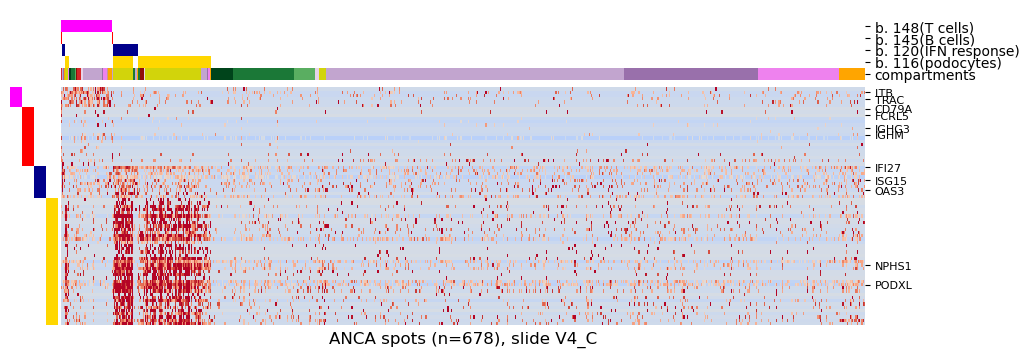

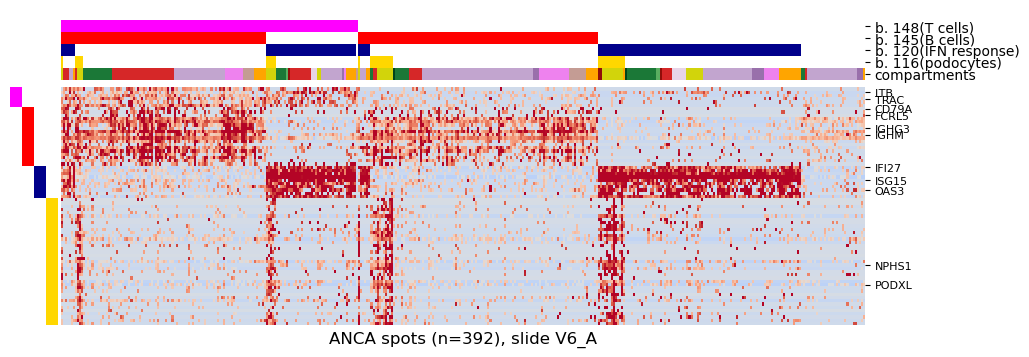

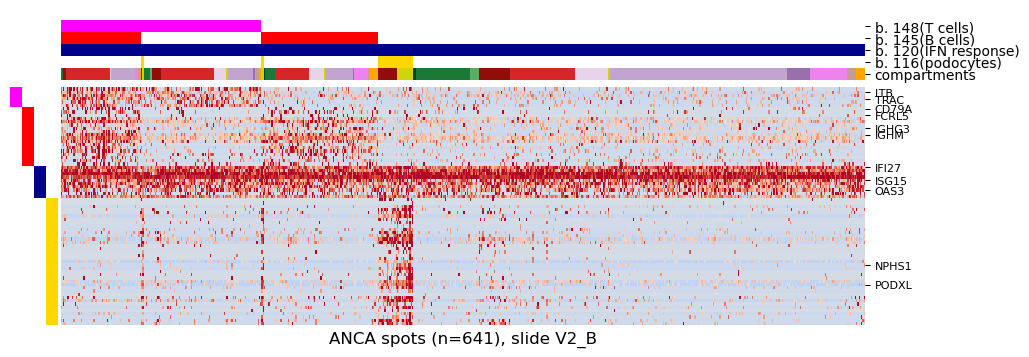

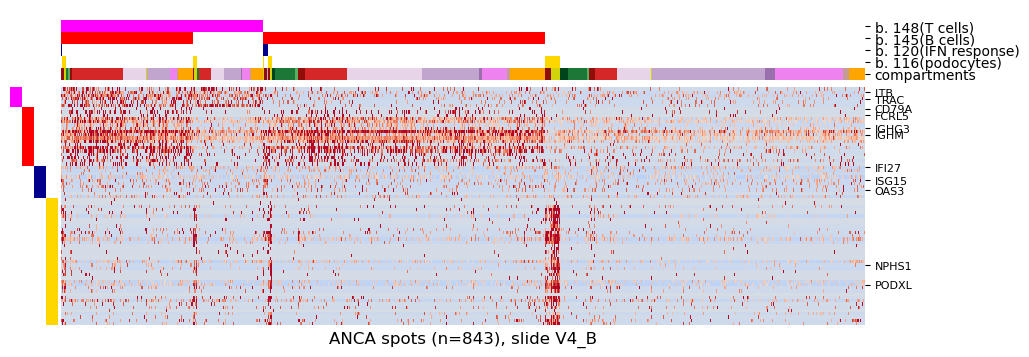

In [40]:
#for slide in sorted(set(annot["Sample"].values)):
for slide in ["V4_C","V6_A","V2_B","V4_B"]: # selected slides
    i = [148,145,120,116] 
    bic_labels = ["T cells", "B cells", "IFN response","podocytes"]

    b = anca_bics.loc[i,:]
    slide_spots = annot.loc[annot["Sample"]==slide,:].index.values
    bic_colors = []
    for bic_id in i:
        if bic_id in bic_to_my_groups.keys():
            bic_colors.append(my_marker_color_dict[bic_to_my_groups[bic_id]])
        else:
            bic_colors.append('black')
    b["genes"] = b["genes"].apply(lambda x: x.intersection(set(exprs_z2.index)))
    b["genes_up"] = b["genes_up"].apply(lambda x: x.intersection(set(exprs_z2.index)))
    b["genes_down"] = b["genes_down"].apply(lambda x: x.intersection(set(exprs_z2.index)))
    b["samples"] = b["samples"].apply(lambda x: x.intersection(set(slide_spots)))

    g,tmp,tmp2 = draw_heatmap2(exprs_z2.loc[:,slide_spots], b,
                        annot = annot2.loc[slide_spots,["cluster_annot"]], # ["Sample","leiden_1","leiden_2","annot_v2","cluster_annot","cluster_annot_broad"]
                        color_dict=color_dict,
                  bicluster_colors= bic_colors,
                  figsize = (10,4), 
                  dendrogram_ratio=(0.01,0.01),
                  colors_ratio=(0.04/10*3.5, 0.04),
                  bic_prefix = "b. ",
                  no_cbar=True,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = False,
                  cluster_rows=False,
                 )

    ytick_labels = g.ax_heatmap.get_yticklabels()
    bic_colors = dict(zip(b.index,bic_colors))
    yticks = g.ax_heatmap.get_yticks()
    new_ytick_labels = []
    new_yticks = []
    for i in range(len(ytick_labels)):
        label = ytick_labels[i]
        yt = yticks[i]
        if label.get_text() in my_marker_genes:
            new_ytick_labels.append(label)
            new_yticks.append(yt)


    ax = g.ax_heatmap

    ax.set_yticks(new_yticks)
    ax.set_yticklabels(new_ytick_labels,fontsize=8)
    g.ax_row_colors.set_xticks([])

    cl =  g.ax_col_colors.get_yticklabels()
    for i in range(len(bic_labels)):
        bl = bic_labels[i]
        cl[i] = cl[i].get_text()+"("+bl+")"
    cl[-1] = "compartments"
    g.ax_col_colors.set_yticklabels(cl)
    ax.set_xlabel("ANCA spots (n=%s), slide %s"%(len(slide_spots),slide),fontsize=12)

    #for ext in ["png","svg","pdf"]:
        #plt.savefig("ST_results/ANCA_specific/ANCA_specific."+slide+"."+ext,dpi = 300)

    # save bicluster memberships and colors
    bic_annot = {}
    for spot in slide_spots:
        bic_annot[spot] = {"compartment":annot2.loc[spot,"cluster_annot"]}
        for bic_id in b.index:
            if spot in b.loc[bic_id,"samples"]:
                bic_annot[spot].update({"b."+str(bic_id): 1, "b."+str(bic_id)+"_color": bic_colors[bic_id]})
            else:
                bic_annot[spot].update({"b."+str(bic_id): 0})
    #pd.DataFrame.from_dict(bic_annot).to_csv("ST_results/ANCA_specific/ANCA_specific."+slide+".tsv.gz")
    #write_bic_table(b,"ST_results/ANCA_specific/ANCA_specific."+slide+"biclusters.tsv.gz")

In [41]:
b

,sample_indexes,n_samples,genes,n_genes,samples,gene_indexes,genes_up,genes_down,SNR
148,"{8195, 4, 6, 8198, 8, 9, 8200, 11, 8203, 16, 8...",2428,"{TRBC2, CD52, TRBC1, TRAC, RAC2, LTB}",6,"{AAGCTCGTGCCAAGTC-1_V4_B, AATATCGAGGGTTCTC-1_V...","{0, 1, 2, 3, 4, 5}","{TRBC2, CD52, TRBC1, TRAC, RAC2, LTB}",{},1.466834
145,"{0, 4, 8198, 8200, 9, 11, 8203, 8204, 14, 16, ...",2502,"{IGHG2, POU2AF1, IGHG3, IGHA1, ZBP1, IGKC, JCH...",18,"{CCGCACAAAGACCAAC-1_V4_B, CACCCGGTTTGTGACT-1_V...","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","{IGHG2, POU2AF1, IGHG3, IGHA1, ZBP1, IGKC, JCH...",{},1.512726
120,"{0, 4, 8196, 8, 9, 22, 23, 24, 25, 26, 27, 29,...",1420,"{RSAD2, OAS3, IFI44L, XAF1, IFI44, OAS2, IFI6,...",10,"{TGACATCGAGCGGACC-1_V4_B, GTTCGGGCGTACCATT-1_V...","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}","{RSAD2, OAS3, IFI44L, XAF1, IFI44, OAS2, IFI6,...",{},1.839932
116,"{8195, 8196, 7, 4104, 11, 12, 8203, 8205, 1025...",616,"{ARMH4, SOST, HTRA1, CRB2, CHI3L1, C1QL1, PCOL...",39,"{TCATTTAAGTCTCCGA-1_V4_B, TACAACGCACAACTCA-1_V...","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","{ARMH4, SOST, HTRA1, CRB2, CHI3L1, C1QL1, PCOL...",{},2.084787
